# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
		* [creates HITs, careful with this one](#creates-HITs,-careful-with-this-one)
* [Reviewing latest HITs](#Reviewing-latest-HITs)
	* [download](#download)
	* [process](#process)
	* [clustering](#clustering)
		* [The two commands above interact with mechanical turk and can take a while](#The-two-commands-above-interact-with-mechanical-turk-and-can-take-a-while)
* [Merging latest round of HITs into combined dataset](#Merging-latest-round-of-HITs-into-combined-dataset)
	* [Load previously pickled results](#Load-previously-pickled-results)
	* [Load prior complete dataset if not in memory](#Load-prior-complete-dataset-if-not-in-memory)
	* [Updating full dataset](#Updating-full-dataset)
	* [Working with full dataset](#Working-with-full-dataset)
		* [worker specific](#worker-specific)
		* [Reviewing full dataset](#Reviewing-full-dataset)
		* [Sanitizing results- questions marked as answers](#Sanitizing-results--questions-marked-as-answers)
* [Worker analysis](#Worker-analysis)
	* [Basic worker stats](#Basic-worker-stats)
		* [HIT duration for pricing](#HIT-duration-for-pricing)
	* [Identifying high and low consensus workers](#Identifying-high-and-low-consensus-workers)
	* [Messaging workers](#Messaging-workers)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle latest results](#Pickle-latest-results)
	* [Pickle combined dataset](#Pickle-combined-dataset)
	* [Accepting and deleting HITs... careful with these](#Accepting-and-deleting-HITs...-careful-with-these)
* [End](#End)


In [419]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import re
from datetime import datetime
import dateutil.parser as dt_parse
import pickle
import boto
import json
import os

from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes

import pdfextraction.amt_boto_modules as amt_util

# Submitting HITs

## Building URLs for images on s3

In [206]:
turk_data_flat_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/turk_data'

In [208]:
diagram_image_names = os.listdir(turk_data_flat_dir)

In [216]:
def make_hit_url(image_cat, image_name, task):
    task_urls = {
        'loc': "https://s3.amazonaws.com/ai2-vision-textbook-dataset/diagrams/annotation/loc/image_text_box_region_labeling.html?",
        'recog': "https://s3.amazonaws.com/ai2-vision-textbook-dataset/diagrams/annotation/recog/image_text_recognition.html?"
        }
    hit_url = task_urls[task] + 'category-image={},{}'.format(image_cat, image_name)
    return hit_url

In [217]:
task_type = 'loc'
hit_urls = [make_hit_url(task_type, image_name, task_type) for image_name in diagram_image_names]

In [255]:
len(hit_urls)

2334

## submitting HITs in groups

In [1753]:
## Switch between sandbox and the real world here ##
## DON'T FORGET to change submission POST request in the client ##

sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = aws_tokes.access_key,
    aws_secret_access_key = aws_tokes.access_secret_key,
    host = real_world_host,
    debug = 1 # debug = 2 prints out all requests.
)
current_account_balance = mturk.get_account_balance()[0]
print current_account_balance # a reminder of sandbox

$75.13


In [231]:
static_params = {
    'title': "Locate Text in Science Diagrams",
    'description': "Draw boxes around text in an image",
    'keywords': ['image', 'science', 'text', 'bounding boxes' ],
    'frame_height': 800,
    'amount': 0.03,
    'duration': 3600 * 12,
    'lifetime': 3600 * 24 * 3,
    'max_assignments': 3
}

In [1131]:
len(images_to_submit)

2332

In [1135]:
results_df.shape[0] /5 * 5 *.05


3535.4500000000003

In [1130]:
expected_cost = len(images_to_submit) *  static_params['amount'] * static_params['max_assignments']
print expected_cost

209.88


### creates HITs, careful with this one

In [236]:
images_to_submit = hit_urls[2:]
expected_cost = len(images_to_submit) *  static_params['amount'] * static_params['max_assignments']
if float(current_account_balance.amount) < expected_cost:
    print('WARNING -- account balance is too low -- WARNING')
print('expect this batch of HITs to cost: $' + str(expected_cost))

expect this batch of HITs to cost: $209.88


uncomment cell below only when ready to submit

In [237]:
# amt_util.create_hits_from_pages(mturk, images_to_submit, static_params)

# Reviewing latest HITs

## download

In [1783]:
r_hits_current_batch = amt_util.get_completed_hits(mturk)
assignment_results_current_batch = amt_util.get_assignments(mturk, r_hits_current_batch)

In [1784]:
len(assignment_results_current_batch)

3671

In [1757]:
len(assignment_results_current_batch) * 3

11013

## process

In [1786]:
print 'current assignment statuses'
print amt_util.get_assignment_statuses(assignment_results_current_batch)

current assignment statuses
Approved    10776
Rejected      237
dtype: int64


In [1675]:
submitted_assignments = defaultdict(list)
for hitid, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        if assignment.AssignmentStatus == 'Submitted':
            submitted_assignments[hitid].append(assignment)

In [1676]:
len(submitted_assignments)

2330

In [258]:
als = pd.Series([len(sas) for sas in submitted_assignments.values()])
als.value_counts()

3    2330
dtype: int64

In [ ]:
submitted_assignments

In [251]:
assignment_results_current_batch.values()[0][0]

In [1691]:
assigment_worker_lookup = {}
for hit_id, hit_assignments in assignment_results_current_batch.items():
        for assignment in hit_assignments:
            assigment_worker_lookup[assignment.AssignmentId]  = assignment.WorkerId

In [1692]:
assigment_worker_lookup

{u'3OWEPKL089DQWB8HGYB75UPR57RN7D': u'A3B0AB2C9SIHN',
 u'3JC6VJ2SABK4PO09J1R5L4RVFU25A1': u'A310C0NYCR23L',
 u'3QAVNHZ3EM5IRD3UBO7C2TNSP05ALH': u'A3OKWRLKLYVH4F',
 u'3DY4FPOOA1PDMZ15R3V4KSA4SLHRVP': u'APLQSM4J9E6LR',
 u'3N1FSUEFL51KRCZLP6ZX6DTN01HD4J': u'A3UNUH7D8FKJ3L',
 u'3VA45EW49NOU3ATRSXUBJ9YJSVYO1Y': u'A13LXDXAWD5DSY',
 u'3AQF3RZ558JV4JHVZ0N2RBGM8516F6': u'ANBTNIM08969Z',
 u'3X3OR7WPZZ148PAFEQNY62HXZC78LD': u'A3GNQDFPZALU92',
 u'31HQ4X3T3SBMR9POSOT3NTHYNQHLS9': u'A3UNUH7D8FKJ3L',
 u'36W0OB37HWFH6PSCWV8DRULUTOWZH9': u'AM1HY736BY3Z8',
 u'3W92K5RLWUIOHC37UWI1HR5804GV55': u'A3BPUFEFCW0M09',
 u'3DPNQGW4LLGL63K6FJRJ07JVJFH465': u'A3VHE7IS4AV96D',
 u'3TVRFO09GKGUNQBNMYZQM1YQ25DLXB': u'A13LXDXAWD5DSY',
 u'3FFJ6VRIL1PK0ZX6YJD6L7JNBUWI0X': u'A2LMQ4497NMK3S',
 u'37QW5D2ZRGNRC255YZKZIOVS3QGS8S': u'A3GCAKQMGAU3ML',
 u'3R2UR8A0IAH2TBEKZQFIEI2KXAROX4': u'AM1HY736BY3Z8',
 u'3VNXK88KKCJ7IZ5JXMVIT7AAM029VD': u'A1RC17FXGMK03J',
 u'3X65QVEQI0O6KS0SV2338ODGRC9CLO': u'A3LD1G3R5NOVYH',
 u'3NGI5ARFTT6CO

In [1703]:
def process_raw_hits(assignments_by_hit):
    mechanical_turk_results = defaultdict(list)
    for hit_id, hit_assignments in assignments_by_hit.items():
        for assignment in hit_assignments:
            for answers in assignment.answers:
                box_result = answers[2].fields[0]
                box_json = json.loads(box_result)
                mechanical_turk_results[hit_id].append({
                    assignment.AssignmentId: {answers[0].fields[0]: box_json}}
                )
    return mechanical_turk_results

In [1704]:
raw_hit_results_current_batch = process_raw_hits(submitted_assignments)

In [1686]:
test_box = raw_hit_results_current_batch.values()[0]
# with open ('diagram_44.jpg.json', 'w') as f:
#     box_json = json.dump(test_box, f)

In [1687]:
test_box

[{u'3BDCF01OGXVJNV1XRULS5F5Z4B6LYG': {u'parts_cell_1182.png': [[[283, 192],
     [447, 238]],
    [[115, 245], [273, 285]],
    [[703, 122], [840, 162]],
    [[958, 88], [1068, 133]],
    [[1165, 98], [1302, 142]],
    [[1243, 175], [1418, 288]],
    [[1192, 822], [1423, 865]],
    [[987, 945], [1397, 1003]],
    [[710, 1025], [862, 1068]],
    [[497, 1038], [642, 1073]],
    [[195, 1032], [455, 1083]],
    [[138, 975], [323, 1015]],
    [[72, 912], [247, 948]],
    [[988, 1038], [1440, 1103]]]}},
 {u'3I2PTA7R3TVZUNSTFKSXDTPIG2RKQG': {u'parts_cell_1182.png': [[[80, 70],
     [493, 147]],
    [[285, 197], [440, 232]],
    [[120, 253], [267, 285]],
    [[705, 127], [843, 162]],
    [[953, 90], [1077, 132]],
    [[1165, 102], [1298, 137]],
    [[1228, 185], [1423, 282]],
    [[1190, 823], [1440, 863]],
    [[60, 910], [252, 945]],
    [[133, 980], [318, 1008]],
    [[200, 1038], [455, 1082]],
    [[493, 1038], [638, 1073]],
    [[715, 1030], [862, 1060]],
    [[995, 955], [1398, 1003]]]}}

In [1708]:
def make_results_df(raw_hit_results):
    col_names = ['diagram', 'rectangle', 'hit_id', 'assignment_id']
    results_df = pd.DataFrame(columns=col_names)
    for hit_id, assignments in raw_hit_results.items():
        for assignment in assignments:
            for a_id, annotation in assignment.items():
                for diagram, rectangles in annotation.items():
                    for box in rectangles:
                        results_df.loc[len(results_df)] = \
                            [diagram, box, hit_id, a_id]
    return results_df

In [133]:
def make_consensus_df(results_df, no_consensus_flag):
    grouped_by_page = results_df.groupby(['diagram'])
    aggregated_df = grouped_by_page.agg(pd.DataFrame.mode)
#     aggregated_df.drop([ 'page', 'box_id', 'worker_id'], axis=1, inplace=True)
    aggregated_df = aggregated_df.fillna(no_consensus_flag)
    consensus_results_df = aggregated_df.reset_index()
    consensus_results_df.drop('level_2', axis=1, inplace=True)
    return consensus_results_df

In [1710]:
results_df = make_results_df(raw_hit_results_current_batch)

In [1764]:
len(results_df['diagram'].unique().tolist())

2307

In [1767]:
ts1  = '1'

In [ ]:
ts1.rsplit()

In [1769]:
sorted(results_df['diagram'].apply(lambda x: x.rsplit('_' , 1)[0]).unique().tolist())

[u'acid_rain_formation',
 u'aquifers',
 u'atomic_mass_number',
 u'atomic_structure',
 u'biomes',
 u'blastocyst',
 u'cell_division',
 u'cellular_respiration',
 u'chemical_bonding_covalent',
 u'chemical_bonding_ionic',
 u'circuits',
 u'continental_drift',
 u'convection_of_air',
 u'cycle_carbon',
 u'cycle_nitrogen',
 u'cycle_rock',
 u'cycle_water',
 u'dna',
 u'earth_day_night',
 u'earth_eclipses',
 u'earth_magnetic_field',
 u'earth_moon_phases',
 u'earth_parts',
 u'earth_poles',
 u'electromagnetism',
 u'em_spectrum',
 u'erosion',
 u'eukaryotic_cell_cycles',
 u'evaporation_and_sublimation',
 u'faults',
 u'food_chains_webs',
 u'fossils',
 u'fungi_reproduction',
 u'geologic_time',
 u'glaciers',
 u'greenhouse_effect',
 u'hair_follicles',
 u'human_system_circulatory',
 u'human_system_digestive',
 u'human_system_ear',
 u'human_system_excretory',
 u'human_system_eye',
 u'human_system_immune',
 u'human_system_muscular',
 u'human_system_nervous',
 u'human_system_reproductory',
 u'human_system_resp

In [1712]:
results_df['worker_id'] = results_df['assignment_id'].apply(lambda x: assigment_worker_lookup[x])

In [1106]:
def get_boxes_by_user(results_df, current_page):
    diagram_df = results_df[results_df['diagram'] == current_page]
    grouped_by_user = diagram_df.groupby( 'assignment_id')
    return {k:v['rectangle'].values for k,v in grouped_by_user}

In [1111]:
tb = get_boxes_by_user(results_df, 'cycle_nitrogen_6714.png')

In [1124]:
np.array(tb.values()[0]).reshape(16, 1)

array([[[[24, 163], [251, 304]]],
       [[[480, 197], [611, 349]]],
       [[[548, 251], [645, 307]]],
       [[[512, 320], [665, 427]]],
       [[[557, 357], [695, 455]]],
       [[[444, 429], [549, 504]]],
       [[[583, 491], [705, 579]]],
       [[[732, 529], [887, 585]]],
       [[[769, 385], [851, 525]]],
       [[[884, 463], [1025, 521]]],
       [[[864, 393], [1023, 431]]],
       [[[803, 323], [993, 379]]],
       [[[997, 329], [1189, 407]]],
       [[[739, 276], [888, 311]]],
       [[[755, 220], [911, 264]]],
       [[[751, 177], [991, 248]]]], dtype=object)

In [1455]:
sorted(pd.unique(results_df['diagram']))[1100:]

[u'layers_of_atmosphere_7069.png',
 u'layers_of_atmosphere_7070.png',
 u'layers_of_atmosphere_7073.png',
 u'layers_of_atmosphere_8100.png',
 u'layers_of_atmosphere_8101.png',
 u'layers_of_atmosphere_8102.png',
 u'lewis_dot_idagrams_9130.png',
 u'lewis_dot_idagrams_9131.png',
 u'lewis_dot_idagrams_9132.png',
 u'lewis_dot_idagrams_9133.png',
 u'lewis_dot_idagrams_9134.png',
 u'lewis_dot_idagrams_9135.png',
 u'lewis_dot_idagrams_9136.png',
 u'lewis_dot_idagrams_9137.png',
 u'lewis_dot_idagrams_9138.png',
 u'lewis_dot_idagrams_9139.png',
 u'lewis_dot_idagrams_9140.png',
 u'lewis_dot_idagrams_9141.png',
 u'lewis_dot_idagrams_9142.png',
 u'lewis_dot_idagrams_9143.png',
 u'lewis_dot_idagrams_9144.png',
 u'lewis_dot_idagrams_9145.png',
 u'lewis_dot_idagrams_9146.png',
 u'lewis_dot_idagrams_9147.png',
 u'lewis_dot_idagrams_9148.png',
 u'lewis_dot_idagrams_9149.png',
 u'life_cycles_101.png',
 u'life_cycles_108.png',
 u'life_cycles_1445.png',
 u'life_cycles_1446.png',
 u'life_cycles_2145.png',
 u

In [1471]:
grouped_by_diagram = results_df.groupby(['diagram', 'assignment_id'])
diagram_agreement = defaultdict(list)
for page_user, boxes in grouped_by_diagram:
    diagram_agreement[page_user[0]].append(len(boxes))

In [1472]:
agreement_series = []
diagrams_with_turker_agreement = []
for page, box_counts in diagram_agreement.items():
#     if len(box_counts) < 2:
#         continue
    if len(box_counts) < 3:
        continue 
    agreement_series.append(len(set(box_counts)))
    if len(set(box_counts)) == 1:
        diagrams_with_turker_agreement.append(page)

In [1473]:
pd.Series(agreement_series).value_counts()

1    1397
2     693
3     191
dtype: int64

In [1469]:
diagram_agreement

defaultdict(list, {})

In [1008]:
diff_series = []
two_turkers_agree_list = 
two_turkers_agree = defaultdict(list)
for page, box_counts in diagram_agreement.items():
    set_list= list(set(box_counts))
    if len(set_list) == 2:
        off_by = abs(set_list[1] - set_list[0])
        diff_series.append(off_by)
        if off_by < 6:
            two_turkers_agree[str(off_by)].append(page)
        else:
            two_turkers_agree['lots'].append(page)
pd.Series(diff_series).value_counts()

1      433
2      108
3       61
4       31
5       11
6        6
11       6
7        4
8        4
12       4
17       2
9        2
10       2
14       2
24       2
60       2
25       1
245      1
115      1
108      1
75       1
50       1
48       1
45       1
42       1
38       1
36       1
35       1
13       1
33       1
27       1
18       1
248      1
dtype: int64

In [1243]:
len(two_turkers_agree['1'])

433

In [1474]:
diff_series = []
no_turkers_agree = defaultdict(list)
for page, box_counts in diagram_agreement.items():
    set_list= list(set(box_counts))
    if len(set_list) == 3:
        off_by = abs(set_list[1] - set_list[0])
        diff_series.append(off_by)
        if off_by < 6:
            no_turkers_agree[str(off_by)].append(page)
        else:
            no_turkers_agree['lots'].append(page)
        diff_series.append(max(set_list) - min(set_list))

## clustering

In [1056]:
def limit_rect(rect, max_x, max_y, border_pad = 2):
        if rect[0][0] < 0:
            rect[0][0] = border_pad
        if rect[0][1] < 0:
            rect[0][1] = border_pad
        if rect[1][0]  > max_x:
            rect[1][0] = max_x - border_pad
        if rect[1][1]  > max_y:
            rect[1][1] = max_y -border_pad
            
def draw_clusters(img_path, clustered_boxes, direction='rows'):
    
    def random_color():
        import random
        return random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)

    image = cv2.imread(img_path)
    max_height, max_width, channels = image.shape

    for idx, cluster in enumerate(clustered_boxes):
        color = random_color()
        for box in cluster:
            limit_rect(box, max_width, max_height)
            cv2.rectangle(image, tuple(box[0]), tuple(box[1]), color=color, thickness=2)
    return image

def draw_loc_clusters(diagram_locs, dest_image_dir = '/Users/schwenk/wrk/stb/check_clustering_km/', bracket=0):
    flattened_topic_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/turk_data/'
    for diagram_name, text_locs in diagram_locs.items():
        try:
            clustered_text_boxes = cluster_diagram_text_centers(text_locs, 3, bracket)
            image_path = flattened_topic_dir + diagram_name
            drawn_image = draw_clusters(image_path, clustered_text_boxes)
            cv2.imwrite(os.path.join(dest_image_dir, diagram_name), drawn_image)
        except OverflowError as e:
            print diagram_name, e

In [1019]:
import numpy as np
from sklearn.cluster import SpectralClustering
import cv2
import PIL.Image as Image
from sklearn.cluster import KMeans


def box_area(box):
    height = box[1][1] - box[0][1]
    width = box[1][0] - box[0][0]
    return height * width

def compute_intersection(b1, b2):
    dx = min(b1[1][0], b2[1][0]) - max(b1[0][0], b2[0][0])
    dy = min(b1[1][1], b2[1][1]) - max(b1[0][1], b2[0][1])
    if (dx >= 0) and (dy >= 0):
        intersection_area = dx * dy
        return intersection_area
    else:
        return

def comp_boxes_iou(b1, b2):
    b1 = b1.reshape(2, 2)
    b2 = b2.reshape(2, 2)
    b1_area = box_area(b1)
    b2_area = box_area(b2)
    intersection = compute_intersection(b1, b2)
    iou = intersection / (b1_area + b2_area - intersection)
    return iou

def comp_box_center(box):
    return [(box[1][0] + box[0][0]) / 2, (box[1][1] + box[0][1]) / 2]

In [1444]:
def pick_consensus(clustered_boxes):
    return [sorted(cluster, key=lambda x: box_area(x))[:1] for cluster in clustered_boxes]
        

def draw_loc_consensus_and_individual(diagram_locs, dest_image_dir = '/Users/schwenk/wrk/stb/check_clustering_km/', bracket=0, results_df=results_df):
    user_image_lookup = defaultdict(lambda: defaultdict(str))
    flattened_topic_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/turk_data/'
    for diagram_name, text_locs in diagram_locs.items():
        try:
            clustered_text_boxes = cluster_diagram_text_centers(text_locs, 3, bracket)
            consensus_boxes = pick_consensus(clustered_text_boxes)
            image_path = flattened_topic_dir + diagram_name
            drawn_image = draw_clusters(image_path, consensus_boxes)
            cv2.imwrite(os.path.join(dest_image_dir, diagram_name.replace('.png', '_consensus.png')), drawn_image)
            user_boxes = get_boxes_by_user(results_df, diagram_name)
            for idx, boxes in enumerate(user_boxes.values()):
                user_image_lookup[diagram_name][idx + 1] = user_boxes.keys()[idx]
                drawn_image = draw_clusters(image_path, np.array(boxes).reshape(len(boxes), 1))
                cv2.imwrite(os.path.join(dest_image_dir, diagram_name.replace('.png', '_' + str(idx + 1) + '.png')), drawn_image) 
        except AttributeError as e:
            print diagram_name, e
    return user_image_lookup

In [1020]:
def cluster_diagram_text(text_rects, n_turkers_assigned = 3):
    n_clusters = int(len(text_rects) / n_turkers_assigned)
    text_clusterer = SpectralClustering(n_clusters, affinity=comp_boxes_iou, assign_labels='kmeans', eigen_solver='arpack', n_init=100)
    box_array = np.array(text_rects)
    box_array = np.array(text_rects)
    box_array_flattened = box_array.reshape(box_array.shape[0], 4)
    box_array_flattened = box_array_flattened.astype(np.float64)
    cluster_assignments = text_clusterer.fit_predict(box_array_flattened)
    clustered_boxes = [box_array[cluster_assignments == cluster_n].tolist() for cluster_n in range(n_clusters)]
    return clustered_boxes

In [1021]:
def cluster_diagram_text_centers(text_rects, n_turkers_assigned = 3, bracket=0):
    text_centers= [comp_box_center(rect) for rect in text_rects]
    remainder = len(text_centers) % n_turkers_assigned
    if not remainder:
        n_clusters = int(len(text_centers) / n_turkers_assigned)
    else:
        if bracket != 'lots':
            bracket_n = int(bracket)
        else:
            bracket_n = 7
        n_clusters = len(text_centers) // n_turkers_assigned + bracket
    text_clusterer = KMeans(n_clusters)
    box_array = np.array(text_centers)
    cluster_assignments = text_clusterer.fit_predict(box_array)
    clustered_boxes = [np.array(text_rects)[cluster_assignments == cluster_n].tolist() for cluster_n in range(n_clusters)]
    return clustered_boxes

In [1188]:
results_df_agreement = results_df[results_df['diagram'].isin(diagrams_with_turker_agreement)]

grouped_by_diagram = results_df_agreement.groupby('diagram')
diagram_locs = defaultdict(list)
for diagram_name, boxes in grouped_by_diagram:
    diagram_locs[diagram_name].extend(boxes['rectangle'].values)

In [1194]:
dest_dir = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/man_pass/all_turkers_agree/'
user_diagram_lookup = draw_loc_consensus_and_individual(diagram_locs, dest_dir)

In [1236]:
with open('user_diag_loopkup.pkl', 'w') as f:
    pickle.dump(dict(user_diagram_lookup), f)

In [1204]:
user_invest = user_diagram_lookup['skin_cross_section_7578.png']

In [1467]:
len(diagrams_with_turker_agreement)

0

In [1427]:
diagrams_with_turker_agreement[0]

u'photosynthesis_4097.png'

In [1436]:
len(set(diagrams_with_turker_agreement).intersection(set(two_turkers_agree['1'])))

0

In [1440]:
len(two_turkers_agree.keys())

7

In [1468]:
sorted(two_turkers_agree.values()[1])

[u'atomic_mass_number_9005.png',
 u'atomic_structure_9016.png',
 u'biomes_8017.png',
 u'cellular_respiration_9046.png',
 u'chemical_bonding_covalent_9052.png',
 u'chemical_bonding_covalent_9055.png',
 u'dna_6763.png',
 u'dna_6767.png',
 u'dna_6769.png',
 u'em_spectrum_6818.png',
 u'faults_1756.png',
 u'geologic_time_6921.png',
 u'geologic_time_6925.png',
 u'human_system_circulatory_3622.png',
 u'human_system_reproductory_7015.png',
 u'hydrocarbons_7051.png',
 u'hydrocarbons_7052.png',
 u'hydrocarbons_8088.png',
 u'hydrocarbons_8089.png',
 u'hydrocarbons_8090.png',
 u'hydrocarbons_8091.png',
 u'hydrocarbons_8092.png',
 u'hydrocarbons_9118.png',
 u'hydrocarbons_9119.png',
 u'hydrocarbons_9122.png',
 u'isotopes_9123.png',
 u'lewis_dot_idagrams_9147.png',
 u'life_cycles_2249.png',
 u'nuclear_energy_8104.png',
 u'nuclear_energy_8106.png',
 u'nuclear_energy_8114.png',
 u'ocean_currents_7109.png',
 u'ocean_zones_8126.png',
 u'parts_cell_994.png',
 u'parts_flower_1014.png',
 u'parts_leaf_6266.

In [1529]:
len(no_turkers_agree_lookup)

0

In [1456]:
two_turkers_agree_lookup = {}
for bracket, diagrams_in_bracket in two_turkers_agree.items():
    out_dir = './con_and_ind/two_turkers_agree_' + str(bracket)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    results_df_two_turkers_agree = results_df[results_df['diagram'].isin(diagrams_in_bracket)]
    grouped_by_diagram = results_df_two_turkers_agree.groupby('diagram')
    diagram_locs_almost = defaultdict(list)
    for diagram_name, boxes in grouped_by_diagram:
        diagram_locs_almost[diagram_name].extend(boxes['rectangle'].values)
    user_lookup = draw_loc_consensus_and_individual(diagram_locs_almost, out_dir, bracket)
    two_turkers_agree_lookup.update(user_lookup)

lewis_dot_idagrams_9147.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9145.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9132.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9130.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9137.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9149.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9133.png 'NoneType' object has no attribute 'shape'


In [1457]:
len(two_turkers_agree_lookup)

690

In [1481]:
with open('no_turkers_agree_lookup.pkl', 'w') as f:
    pickle.dump(dict(no_turkers_agree_lookup), f)

In [1530]:
no_turkers_agree_lookup = {}
for bracket, diagrams_in_bracket in no_turkers_agree.items():
    out_dir = './con_and_ind/no_turkers_agree_' + str(bracket)
#     if not os.path.exists(out_dir):
#         os.mkdir(out_dir)
    results_df_two_turkers_agree = results_df[results_df['diagram'].isin(diagrams_in_bracket)]
    grouped_by_diagram = results_df_two_turkers_agree.groupby('diagram')
    diagram_locs_almost = defaultdict(list)
    for diagram_name, boxes in grouped_by_diagram:
        diagram_locs_almost[diagram_name].extend(boxes['rectangle'].values)
    user_lookup = draw_loc_consensus_and_individual(diagram_locs_almost, out_dir, bracket)
    no_turkers_agree_lookup.update(user_lookup)

lewis_dot_idagrams_9148.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9138.png 'NoneType' object has no attribute 'shape'
lewis_dot_idagrams_9146.png 'NoneType' object has no attribute 'shape'


In [1533]:
len(no_turkers_agree_lookup)

188

In [1459]:
len(no_turkers_agree)

0

In [1030]:
for bracket, diagrams_in_bracket in no_turkers_agree.items():
    out_dir = './con_and_ind/no_turkers_agree_' + bracket 
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    results_df_two_turkers_agree = results_df[results_df['diagram'].isin(diagrams_in_bracket)]
    grouped_by_diagram = results_df_two_turkers_agree.groupby('diagram')
    diagram_locs_almost = defaultdict(list)
    for diagram_name, boxes in grouped_by_diagram:
        diagram_locs_almost[diagram_name].extend(boxes['rectangle'].values)
    draw_loc_clusters(diagram_locs_almost, out_dir, bracket)

In [1419]:
# draw_loc_clusters(diagram_locs_almost, '/Users/schwenk/wrk/stb/check_clustering_km_almost_agree/')

## single test

In [1149]:
grouped_by_diagram = results_df.groupby('diagram')
diagram_locs = defaultdict(list)
for diagram_name, boxes in grouped_by_diagram:
    diagram_locs[diagram_name].extend(boxes['rectangle'].values)

In [1211]:
user_invest[1]

u'374TNBHA8BWUESHAJZTOM14TEH3YQS'

In [1227]:
problem = diagram_locs[problem_name]

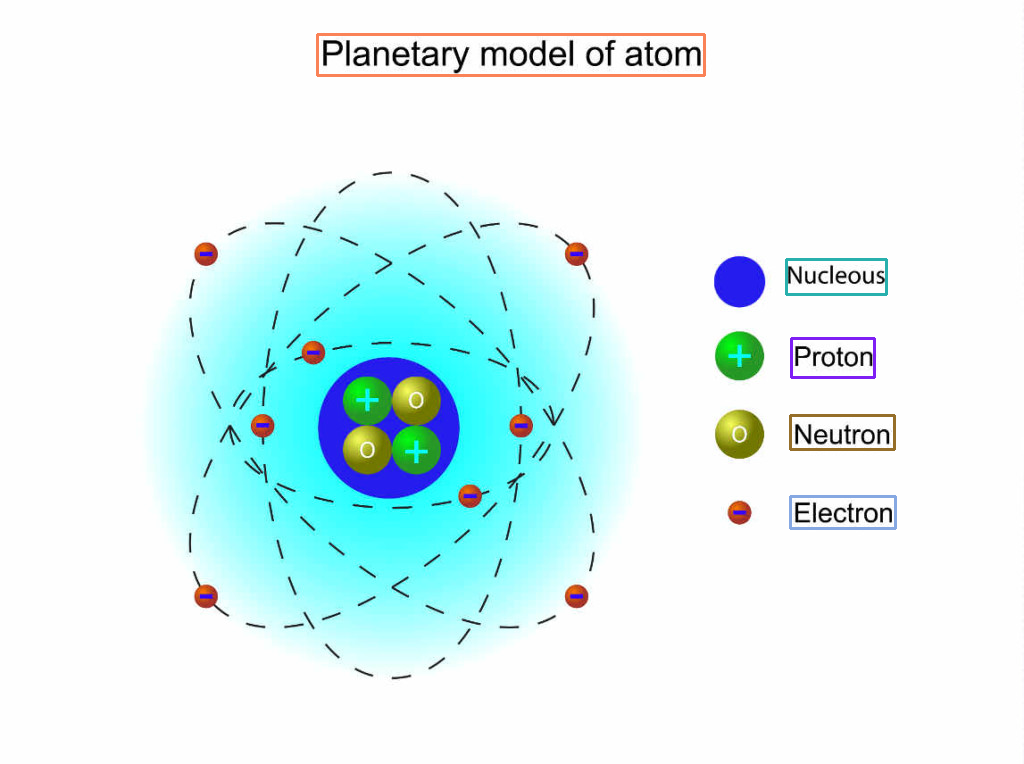

In [1231]:
problem_name = 'atomic_structure_8007.png'
problem = diagram_locs[problem_name]

user_invest = user_diagram_lookup[problem_name]
ind_user_df = results_df_agreement[(results_df_agreement['diagram'] == problem_name) & (results_df_agreement['assignment_id'] == user_invest[1])]

image_path = flattened_topic_dir + problem_name
# clustered_text_boxes_centers = cluster_diagram_text_centers(problem)
user_boxes = ind_user_df['rectangle'].values
drawn_image = draw_clusters(image_path, np.array(user_boxes).reshape(len(user_boxes), 1))
Image.fromarray(drawn_image)

In [1004]:
[clust for clust in clustered_text_boxes_centers if len(clust) != 3]

[[[[526, 454], [715, 478]], [[535, 463], [711, 478]]]]

### The two commands above interact with mechanical turk and can take a while

In [9]:
results_df_current_batch = amt_util.make_results_df(raw_hit_results_current_batch)
consensus_results_df_current_batch = amt_util.make_consensus_df(results_df_current_batch, 'No Consensus')

In [10]:
%%capture
no_consensus_hits = consensus_results_df_current_batch[consensus_results_df_current_batch['category'] == 'No Consensus']

In [102]:
flaw_rate = len(no_consensus_hits) / len(consensus_results_df_current_batch)
print 'text boxes without consensus comprise ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

text boxes without consensus comprise 2.87% of the total


In [423]:
amt_util.write_results_df(consensus_results_df_current_batch)

In [419]:
# all pages from the latest batch
pages_to_review =pd.unique(consensus_results_df_current_batch['page'])

In [384]:
# all pages from the latest batch with a no-consensus box
pages_to_review =pd.unique(no_consensus_hits['page'])

In [424]:
sampling_rate = 1
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

amt_util.review_results(to_review)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

sampling 17 pages out of 17
posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


In [438]:
amt_util.count_pages_with_cat(combined_consensus_df, 'Question')

1337

In [73]:
%%capture 
# all pages from the latest batch with a no-consensus box
suspect_subset = results_df_current_batch[results_df_current_batch['worker_id'].isin(suspect_workers[:5])]
amt_util.write_results_df(suspect_subset)
pages_to_review = pd.unique(suspect_subset['page'])

## reading consensus choices

In [1314]:
import re

In [1264]:
man_pass_dir = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/man_pass/'
final_res = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/final_diagrams/'

In [1308]:
my_selections = pd.read_csv(man_pass_dir + 'final_consensus_all_turkers', header=None)
my_selections.columns = ['idx', 'diagram', 'selected_idx', 'not']
del my_selections['not']

my_selections['diagram'] = my_selections['diagram'].apply(lambda x: x.lstrip())

In [1262]:
my_selections['selected_idx'].value_counts()

0    1267
1      52
3      40
2      38
Name: selected_idx, dtype: int64

In [1519]:
def draw_final_individual(diagram_locs, dest_dir, user_diagram_lookup, diagram_selection_lookup, results_df=results_df):
    boxes_to_use = {}
    flattened_topic_dir = '/Users/schwenk/wrk/stb/ai2-vision-textbook-dataset/diagrams/turk_data/'
    for diagram_name, text_locs in diagram_locs.items():
        image_path = flattened_topic_dir + diagram_name
        name_to_match = diagram_name.replace('.png', '').replace('_1', '')
        if diagram_selection_lookup[name_to_match] == 0:
            clustered_text_boxes = cluster_diagram_text_centers(text_locs, 3, bracket)
            consensus_boxes = pick_consensus(clustered_text_boxes)
            boxes_to_use[diagram_name] = consensus_boxes
#             try:
#                 drawn_image = draw_clusters(image_path, consensus_boxes)
#             except AttributeError:
#                 print diagram_name   
        else:
            this_diagrams_users = user_diagram_lookup[diagram_name]
            selected_user = this_diagrams_users[diagram_selection_lookup[name_to_match]]
            user_boxes = get_boxes_by_user(results_df, diagram_name)
            selected_boxes = user_boxes[selected_user]
            boxes_to_use[diagram_name] = selected_boxes.reshape(len(selected_boxes), 1).tolist()
#             drawn_image = draw_clusters(image_path, np.array(selected_boxes).reshape(len(selected_boxes), 1))
#       cv2.imwrite(os.path.join(dest_dir, diagram_name), drawn_image) 
    return boxes_to_use

## pass 2

In [1535]:
len(no_turkers_agree_lookup.keys())

188

In [1538]:
results_df_lesser_agreement = results_df[results_df['diagram'].isin(no_turkers_agree_lookup.keys() + two_turkers_agree_lookup.keys())]

grouped_by_diagram_lesser = results_df_lesser_agreement.groupby('diagram')
diagram_locs_lesser = defaultdict(list)
for diagram_name, boxes in grouped_by_diagram_lesser:
    diagram_locs_lesser[diagram_name].extend(boxes['rectangle'].values)

In [1539]:
len(diagram_locs_lesser)

878

In [1638]:
def read_consensus_decisions(record_file, man_pass_dir):
    bracket_consensus = pd.read_csv(man_pass_dir + record_file , header=None)
    bracket_consensus.columns = ['idx', 'diagram', 'selected_idx', 'not']
    del bracket_consensus['not']
    bracket_consensus['diagram'] = bracket_consensus['diagram'].apply(lambda x: x.lstrip())
    bracket_consensus['selected_idx'] = bracket_consensus['selected_idx'].apply(lambda x: x.lstrip())
    return bracket_consensus

def convert_df_to_dict(con_df): 
    con_df_red = con_df[['selected_idx', 'diagram']]
    return con_df_red.set_index('diagram').to_dict()['selected_idx']

In [1639]:
record_files = ['final_consensus_two_turkers', 'final_consensus_harder_two_turkers', 'final_consensus_no_turkers', 'final_consensus_harder_no_turkers']
test_consensus = read_consensus_decisions(record_files[0], man_pass_dir)

In [1643]:
test_consensus['selected_idx'].value_counts()

KeyError: 'selected_idx'

In [1645]:
pd.Series(combined_pass_2_lookup.values()).value_counts()

0       345
1       165
2       159
3       134
         35
redo      2
dtype: int64

In [1646]:
combined_pass_2_lookup = {}
for con_record in record_files:
    consensus_df = read_consensus_decisions(con_record, man_pass_dir)
    record_lookup = convert_df_to_dict(consensus_df)
    combined_pass_2_lookup.update(record_lookup)

In [1668]:
blacklisted_topics = ['periodic_table', 'em_spectrum', 'hydrocarbons', 'geologic_time'] + ['lewis_dot_idagrams']  # correct this mispelling in future round

In [1671]:
2093 / (len(combined_pass_2_lookup) + 1349)

0.9561443581544085

In [1669]:
(len(combined_pass_2_lookup) + 1349) / 2265

0.9664459161147902

In [1624]:
def make_boxes_to_recog(diagram_locs, user_diagram_lookup, diagram_selection_lookup, results_df=results_df):
    boxes_to_use = {}
    for diagram_name, text_locs in diagram_locs.items():
        name_to_match = diagram_name.replace('.png', '')
        try:
            if name_to_match
            if diagram_selection_lookup[name_to_match] == '0':
                clustered_text_boxes = cluster_diagram_text_centers(text_locs, 3, bracket)
                consensus_boxes = pick_consensus(clustered_text_boxes)
                boxes_to_use[diagram_name] = consensus_boxes
            else:
                this_diagrams_users = user_diagram_lookup[diagram_name]
    #             print this_diagrams_users
    #             print diagram_selection_lookup[name_to_match]
                selected_idx = diagram_selection_lookup[name_to_match]
                if selected_idx == 'redo':
                    continue
                else:
                    selected_idx = int(selected_idx)
                selected_user = this_diagrams_users[selected_idx]
                user_boxes = get_boxes_by_user(results_df, diagram_name)
    #             print selected_user
                selected_boxes = user_boxes[selected_user]
                boxes_to_use[diagram_name] = selected_boxes.reshape(len(selected_boxes), 1).tolist()
        except KeyError as e:
#             print diagram_name
            print e
    return boxes_to_use

In [1629]:
combined_lesser_user_lookup = deepcopy(no_turkers_agree_lookup)
combined_lesser_user_lookup.update(two_turkers_agree_lookup)

In [1672]:
# combined_lesser_user_lookup['food_chains_webs_261']

In [1648]:
%%time
final_boxes_to_recog = make_boxes_to_recog(diagram_locs_lesser, combined_lesser_user_lookup, combined_pass_2_lookup, results_df)

u'geologic_time_6924'
u'hydrocarbons_8090'
u'hydrocarbons_8092'
u'periodic_table_7396'
u'hydrocarbons_8088'
u'periodic_table_8161'
u'hydrocarbons_9118'
u'hydrocarbons_8089'
u'periodic_table_7356'
u'periodic_table_7386'
u'periodic_table_8160'
u'periodic_table_8157'
u'periodic_table_7385'
u'geologic_time_6917'
u'em_spectrum_6819'
u'hydrocarbons_9119'
u'periodic_table_8162'
u'em_spectrum_6816'
u'geologic_time_6925'
u'hydrocarbons_9122'
u'dna_6769'
u'geologic_time_6919'
u'periodic_table_7392'
u'geologic_time_6921'
u'periodic_table_7393'
u'geologic_time_6923'
u'hydrocarbons_7051'
u'periodic_table_7381'
u'hydrocarbons_8095'
u'hydrocarbons_8091'
u'em_spectrum_9094'
u'periodic_table_8159'
u'geologic_time_6918'
u'periodic_table_7352'
u'periodic_table_8158'
u'hydrocarbons_7052'
u'geologic_time_6914'
u'periodic_table_7419'
u'hydrocarbons_8094'
CPU times: user 8.34 s, sys: 64.5 ms, total: 8.4 s
Wall time: 8.39 s


In [1666]:
box_dest_dir = '/Users/schwenk/wrk/stb/diagram_questions/turk_processing/final_text_boxes_pass_2/'

for diagram_name, boxes in final_boxes_to_recog.items():
    with open(box_dest_dir + diagram_name + '.json', 'w') as f:
        json.dump([box[0] for box in boxes if box], f)

In [1653]:
n_box_series = [len(boxes) for boxes in final_boxes_to_recog.values()]
pd.Series(n_box_series).value_counts()

9     66
13    62
12    62
10    61
11    56
8     54
14    50
16    46
7     41
15    38
6     34
18    29
17    22
5     22
20    19
4     17
21    16
19    16
26    12
23    12
24     8
27     8
3      8
22     5
28     4
30     4
33     4
25     3
29     3
1      2
31     2
32     2
38     2
64     1
34     1
35     1
36     1
40     1
41     1
42     1
44     1
46     1
57     1
61     1
62     1
66     1
dtype: int64

In [1654]:
image_and_n_boxes = {name: len(boxes) for name, boxes in final_boxes_to_recog.items()}
with open('box_n_2.pkl', 'w') as f:
    pickle.dump(image_and_n_boxes, f)

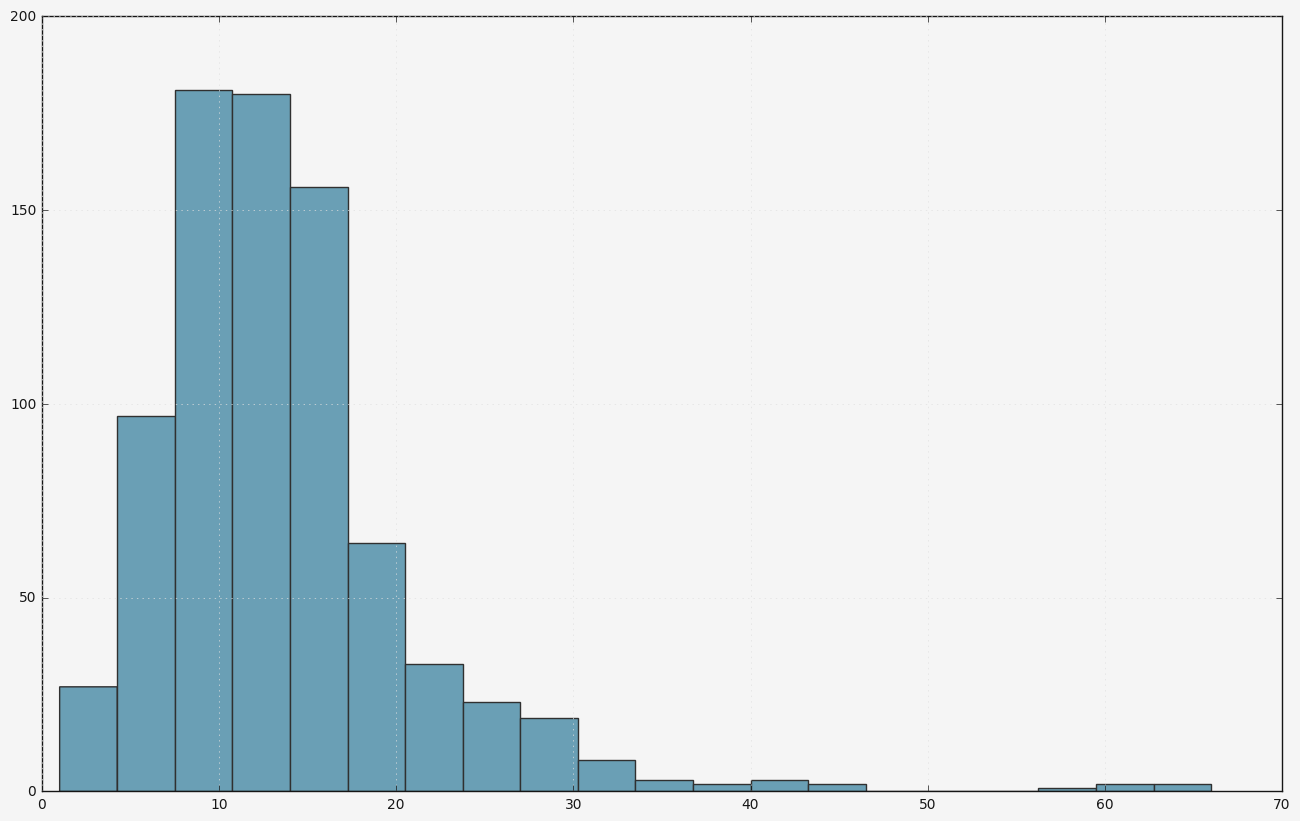

In [1655]:
_ = pd.Series([len(boxes) for boxes in final_boxes_to_recog.values()]).hist(bins = 20)

In [1286]:
get_boxes_by_user(results_df, 'acid_rain_formation_6505.png')

{u'30BXRYBRP4YDCUN7L8O6SQRCCLKWH6': array([[[527, 55], [723, 118]], [[997, 87], [1253, 187]],
        [[1070, 648], [1447, 752]], [[45, 465], [388, 600]]], dtype=object),
 u'3907X2AHF06JDVNOQ174DSDEU62P2R': array([[[515, 53], [728, 130]], [[985, 78], [1262, 183]],
        [[1063, 645], [1465, 753]], [[42, 458], [405, 600]]], dtype=object),
 u'3H7Z272LX78PEH9W07P9SOCN06UPLH': array([[[525, 58], [727, 115]], [[45, 458], [392, 600]],
        [[1060, 648], [1448, 742]], [[997, 85], [1250, 185]]], dtype=object)}

# Merging latest round of HITs into combined dataset 

## Load previously pickled results

In [383]:
batch_number = 7

with open('./store_hit_results_metadata/group_' + str(batch_number) + '/hit_info.pkl') as f:
    r_hits_previous_batch = pickle.load(f)
    
with open('./store_hit_results_metadata/group_' + str(batch_number) + '/assignment_info.pkl') as f:
    assignment_results_previous_batch = pickle.load(f)
    
# with open('./store_hit_results_metadata/group_' + str(batch_number) + '/raw_res.pkl') as f:
#     raw_hit_results_previous_batch = pickle.load(f)

In [397]:
# combined_results_batch = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
# combined_consensus_batch = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')

In [405]:
missing_hits = set(assignment_results_previous_batch.keys()).difference(assignment_results_current_batch.keys())
missing_hits_assignments = {k: v for k, v in assignment_results_previous_batch.items() if k in missing_hits}

## Load prior complete dataset if not in memory

In [2]:
data_pickled_dir = './store_hit_results_metadata/group_latest_combined/' 

In [3]:
combined_results_df = pd.read_pickle(data_pickled_dir + 'complete_df.pkl')
combined_consensus_df = pd.read_pickle(data_pickled_dir + 'consensus_df.pkl')
combined_consensus_with_workerid_df = pd.read_pickle(data_pickled_dir + 'consensus_df_w_workers.pkl') 

## Updating full dataset

In [426]:
combined_results_df = combined_results_df.append(results_df_previous_batch)
combined_consensus_df = combined_consensus_df.append(consensus_prev)
combined_consensus_with_workerid_df = combined_consensus_with_workerid_df.append(consensus_prevww)

In [4]:
%%capture
no_consensus_hits = combined_consensus_df[combined_consensus_df['category'] == 'No Consensus']

## Working with full dataset

### worker specific

In [961]:
flaw_rate = len(no_consensus_hits) / len(combined_consensus_df)
print 'text boxes without consensus are ' + '{0:0.2f}% '.format(flaw_rate * 100) + 'of the total'  

In [255]:
workers_to_qualify = worker_quality_df[worker_quality_df['submitted'] > 100].sort_values('flaw_ratio', ascending= True).head(25).index.tolist()

In [ ]:
workers_to_qualify

In [242]:
bad_and_prolific_workers[:15]

,submitted,incorrect,flaw_ratio
A2KM2RWXQV47CV,2900.0,2093.0,0.721724
A16EEWCUQK9LM2,1069.0,446.0,0.417212
A1QZHZZMO2TE51,582.0,215.0,0.369416
A2XJH3WC02RMXQ,134.0,87.0,0.649254
AQE7EQDM98KB7,154.0,47.0,0.305195
A18DRAESIN3E94,112.0,43.0,0.383929
A8TDOYC7FWWKR,67.0,36.0,0.537313
A9Y1HKUEOOEPM,49.0,35.0,0.714286
A1EGJ4WHHIU61V,45.0,24.0,0.533333
A1ESKJFDQUMBL4,68.0,23.0,0.338235


workers who contacted me

In [256]:
wrote_me = ['A3T8FDBJQV81FN',
'A3UUH3632AI3ZX',
'A2QVMCGDLTWV9',
'A356GXVAYWN0DV',
'A2V4PRG5UBNIX0',
'A333VJ2K6O6R79']

In [258]:
workers_to_ban = bad_and_prolific_workers[:5].index.tolist()
set(bad_and_prolific_workers.index).intersection(set(wrote_me))

{'A2V4PRG5UBNIX0'}

In [275]:
workers_to_ban

[u'A2KM2RWXQV47CV',
 u'A16EEWCUQK9LM2',
 u'A1QZHZZMO2TE51',
 u'A2XJH3WC02RMXQ',
 u'AQE7EQDM98KB7']

In [260]:
combined_consensus_with_workerid_df.head()

,assignment_id,box_id,category,consensus_category,hit_id,page,worker_id
8126,32AT8R96GLAPAZCI12L4EGDHN25US0,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8144,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6
8162,3N2BF7Y2VQVH7ITTH6IJJSPL15VMHP,T1,unlabeled,unlabeled,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A2RSOGTSR83XKO
8131,32AT8R96GLAPAZCI12L4EGDHN25US0,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A333VJ2K6O6R79
8149,3WJ1OXY92AHNC6JBHZY8XO1M45D8A9,T10,Discussion,Discussion,302OLP89DZ8M1PBU899CBQ2L0VSAC8,Daily_Science_Grade_4_Evan_Moor_55.jpeg,A36PFUM96J0ES6


After looking through the top few offenders, it's clear that 

1. the very worst intentionally submitted many blank pages

2. the rest didn't read the directions very closely

3. I'm comfortable rejecting the work of those with > 100 submissions

4. I'll ban the worst 15 from future HITs


### Reviewing full dataset

In [94]:
amt_util.write_results_df(combined_consensus_df, local_result_path)

In [4]:
# all pages from the complete
pages_to_review =pd.unique(combined_consensus_df['page'])

In [5]:
combined_consensus_df[combined_consensus_df['category'] == 'Question'].shape

(16986, 4)

In [6]:
pages_to_review =pd.unique(combined_consensus_df[combined_consensus_df['category'] == 'Question']['page'])

In [7]:
# all pages from the complete dataset with a no-consensus box
# pages_to_review =pd.unique(no_consensus_hits['page'])

In [8]:
sampling_rate = 0.30
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 401 pages out of 1337


In [39]:
overmerged_dir = 'labeled-annotations/'
unmerged_dir = 'annotations_ws/'
lessmerged_dir = 'lessmerged-annotations/'
remerged_annotations  = 'test-remerged-annotations/'
anno_dir = lessmerged_dir
amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


In [ ]:
# %%capture 
# # all pages from the latest batch with a no-consensus box

# # suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(bad_and_prolific_to_review[10:15])]
# suspect_subset = combined_results_df[combined_results_df['worker_id'].isin(['A3VE5OH94HYHET'])]
# amt_util.write_results_df(suspect_subset)
# pages_to_review = pd.unique(suspect_subset['page'])

### Sanitizing results- questions marked as answers

In [67]:
question_only_df = combined_consensus_df[combined_consensus_df['category'] == 'Question']

In [68]:
pages_w_questions = pd.unique(question_only_df['page'])
len(pages_w_questions)

1337

In [69]:
combined_df_question_pages_only = combined_consensus_df[combined_consensus_df['page'].isin(pages_w_questions)]

In [111]:
combined_df_question_pages_only.to_pickle('pages_w_questions.pkl')

In [70]:
question_pages_w_answers = pd.unique(combined_df_question_pages_only[combined_df_question_pages_only['category'] == 'Answer']['page'])

In [71]:
question_pages_w_answers.shape

(49,)

In [72]:
incorrectly_marked_answers_df = combined_consensus_df[combined_consensus_df['page'].isin(question_pages_w_answers)]

In [73]:
pd.unique(incorrectly_marked_answers_df['page']).shape

(49,)

In [83]:
to_correct_aq_df = combined_consensus_df[combined_consensus_df['page'].isin(incorrectly_marked_answers_df['page'])]

In [88]:
corrected_aq_df = to_correct_aq_df.replace('Answer', 'Question')

In [105]:
local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_raw_hit_results/'
# local_result_path='./ai2-vision-turk-data/textbook-annotation-test/corrected_unmerged/'

amt_util.write_results_df(corrected_aq_df, local_result_path)

In [106]:
pages_to_review = pd.unique(corrected_aq_df['page'])
sampling_rate = 1
sample_size = int(len(pages_to_review) * sampling_rate)
sampled_pages_to_review = list(np.random.choice(pages_to_review, size= sample_size, replace=False))
print 'sampling ' + str(sample_size) + ' pages out of ' + str(len(pages_to_review))
to_review = ['start_seq'] + sampled_pages_to_review

sampling 49 pages out of 49


In [109]:
# anno_dir = 'corrected_unmerged/'
anno_dir = 'test-remerged-annotations/'

amt_util.review_results(to_review, anno_dir)
print 'posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results'

posting to review tool, navigate to http://localhost:8080/ to see the sampled consensus results


# Worker analysis

## Basic worker stats

In [1726]:
results_df

,diagram,rectangle,hit_id,assignment_id,worker_id
0,parts_cell_1182.png,"[[283, 192], [447, 238]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
1,parts_cell_1182.png,"[[115, 245], [273, 285]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
2,parts_cell_1182.png,"[[703, 122], [840, 162]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
3,parts_cell_1182.png,"[[958, 88], [1068, 133]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
4,parts_cell_1182.png,"[[1165, 98], [1302, 142]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
5,parts_cell_1182.png,"[[1243, 175], [1418, 288]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
6,parts_cell_1182.png,"[[1192, 822], [1423, 865]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
7,parts_cell_1182.png,"[[987, 945], [1397, 1003]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
8,parts_cell_1182.png,"[[710, 1025], [862, 1068]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB
9,parts_cell_1182.png,"[[497, 1038], [642, 1073]]",3SA4EMRVJV39U1MGLCYP6KPFULH0PX,3BDCF01OGXVJNV1XRULS5F5Z4B6LYG,A1017VP86SLXRB


In [1714]:
print 'number of unique workers:'
pd.unique(results_df['worker_id']).shape[0]

number of unique workers:


177

In [1724]:
grouped_by_worker = results_df.groupby('worker_id')

In [1737]:
grouped_by_worker['rectangle'].aggregate(len)

worker_id
A03922113RU44GENR8ATX     146
A1017VP86SLXRB            862
A10443E11ZWEHJ             13
A107QUL9WE39ZV            105
A10PVSMU1UBP8N            292
A111JI6APXR6QV             41
A11MPIAKPRMF9T             61
A122E99M2DQY1G             39
A127F80LLYOQ22              2
A13LXDXAWD5DSY           1369
A13PFEJFK3DI9B            724
A14YUE2S0RRKY1             30
A150BOXII7BKNP             43
A154D85W3BLY4U            629
A15CDKMH6YDJ39             21
A16DZUAE29Z21H            160
A16PK8DLMV0XLW            949
A18ZUFGMNOVI2Y           1241
A198X28FHY2OY0            422
A19GQT4YCUWHIO             65
A19ZOKX8M6VWOO            191
A1D4I1QYL9713I            603
A1D4Z17JF8TE4Y            485
A1EFMDT1U0TBPV             10
A1EGJBJBFBZJBA            864
A1G3G0YQ80PTL9            235
A1HC5X6E6ZGINB            119
A1IM9SPV7X9P6W            508
A1ISG85JD2NXKK             63
A1M1T2EF4Y2IW8             39
                         ... 
AB66CTVQ90RCV              68
AB6F473EMJD8Y             236


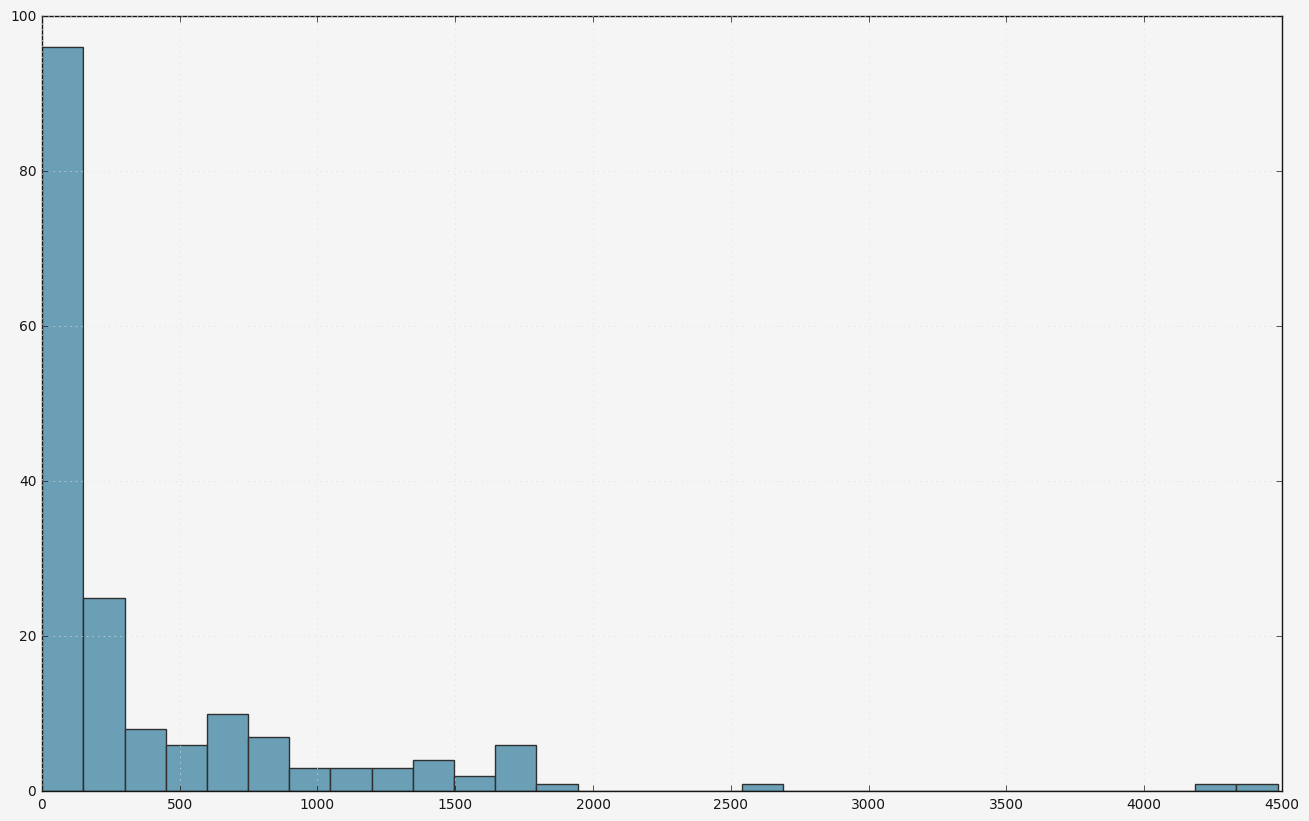

In [1716]:
_ = results_df['worker_id'].value_counts().hist(bins= 30)

### HIT duration for pricing

In [1718]:
task_duration_seconds = []
for hit_id, assignments in assignment_results_current_batch.items():
    for assignment in assignments:
        hit_duration = dt_parse.parse(assignment.SubmitTime) - dt_parse.parse(assignment.AcceptTime)
        task_duration_seconds.append(hit_duration.seconds)

In [1719]:
task_duration_series = pd.Series(task_duration_seconds)

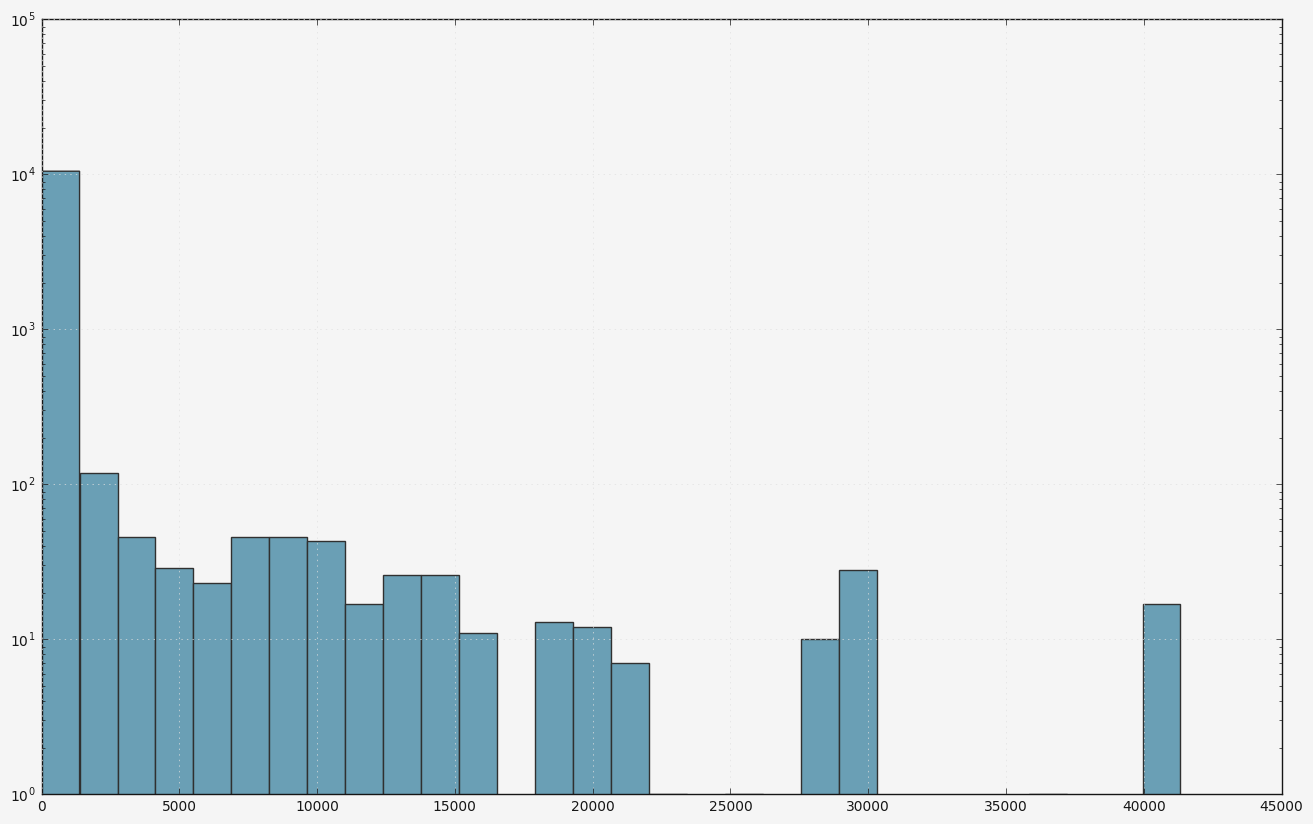

In [1720]:
_ = task_duration_series.hist(bins=30, log=True)

In [1721]:
winsorized_durations = [t for t in task_duration_seconds if t < 300]
w_duration_series = pd.Series(winsorized_durations)

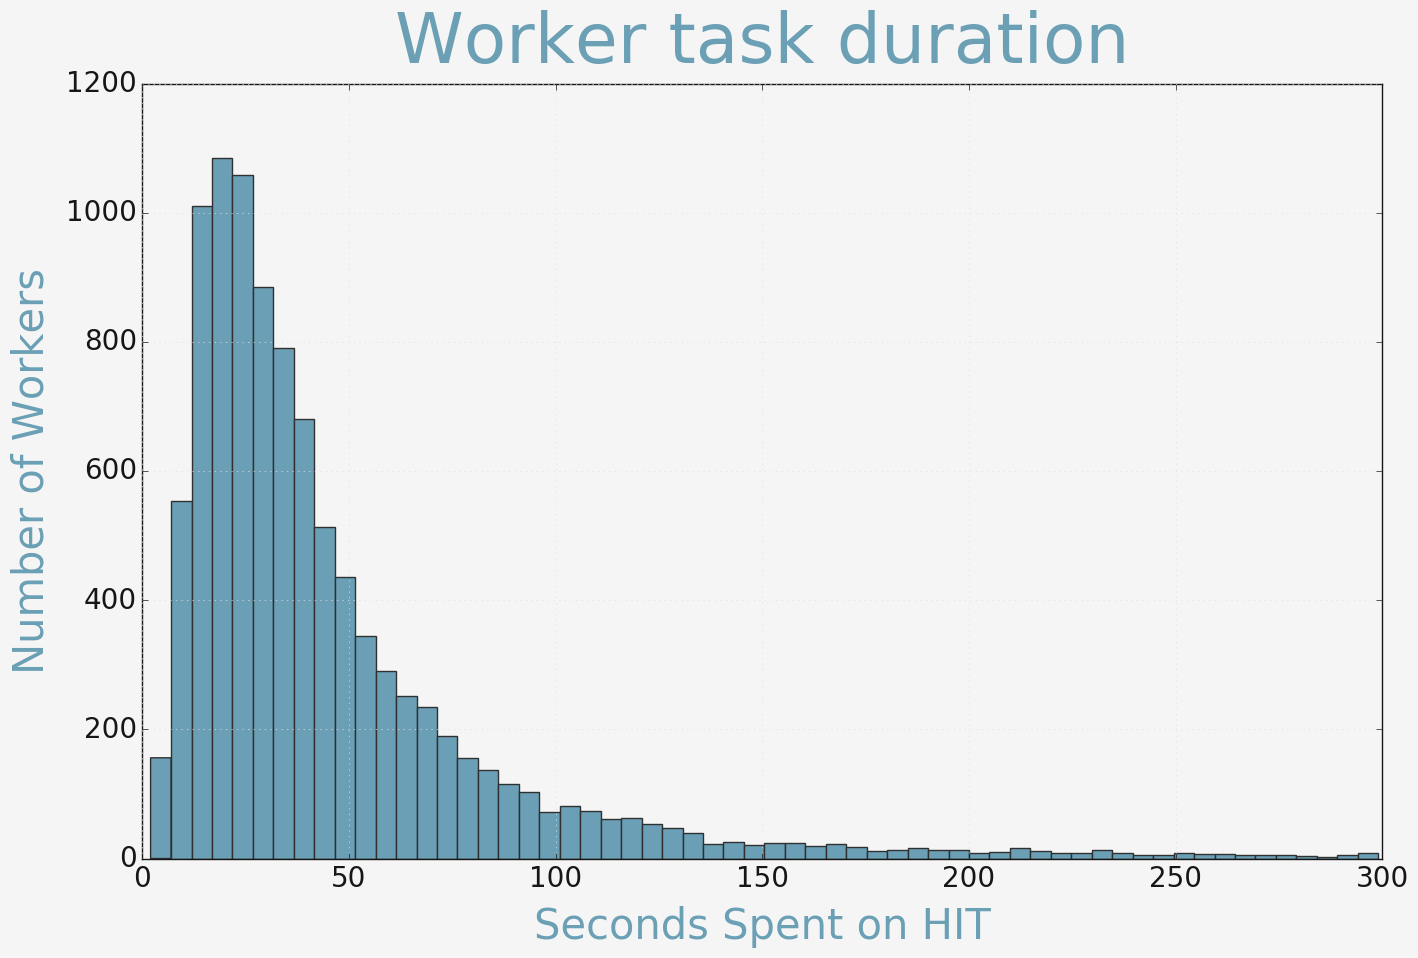

In [1722]:
_ = pd.Series(w_duration_series).hist(bins=60)
plt.title('Worker task duration', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Number of Workers", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Seconds Spent on HIT", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [1723]:
print 'duration mode= ' + str(w_duration_series.mode().values[0])
print 'duration median= ' + str(w_duration_series.median())

duration mode= 22
duration median= 33.0


## Identifying high and low consensus workers

In [113]:
consensus_with_workerid_df_this_batch = amt_util.make_consensus_df_w_worker_id(results_df_current_batch, consensus_results_df_current_batch)

In [138]:
len(pd.unique(worker_conflicts['worker_id']))

175

In [113]:
worker_conflicts = combined_consensus_with_workerid_df[combined_consensus_with_workerid_df['category'] != combined_consensus_with_workerid_df['consensus_category']]
all_worker_counts = combined_results_df['worker_id'].value_counts()
bad_worker_counts = worker_conflicts['worker_id'].value_counts()
worker_quality_df = pd.DataFrame([all_worker_counts, bad_worker_counts]).T
worker_quality_df.columns=['submitted', 'incorrect']
worker_quality_df['flaw_ratio'] = worker_quality_df['incorrect']/worker_quality_df['submitted']

good_workers = worker_quality_df.sort_values('flaw_ratio', ascending= True).index.tolist()

suspect_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).index.tolist()

worker_quality_df.sort_values('flaw_ratio', ascending= True).head(10)

,submitted,incorrect,flaw_ratio
A3JOFB6Z65I37Q,124.0,2.0,0.016129
A2HTN7HCNBQ8V4,157.0,3.0,0.019108
A22FK64IWET30E,45.0,1.0,0.022222
AEWGY34WUIA32,1538.0,40.0,0.026008
ASB8T0H7L99RF,507.0,14.0,0.027613
AMA18W8F60Y2J,100.0,3.0,0.030000
A2YY1ZR7Z4VT4M,1517.0,54.0,0.035597
AJFVK3O1D7SPE,1141.0,42.0,0.036810
A10M8ULK8QMRU6,27.0,1.0,0.037037
A2HM35CWB7IIFM,26.0,1.0,0.038462


I became concerned that I missed the perfect performers, but as I suspected perfect workers only did 1-2 HITs at most

In [147]:
aw_set = set(all_worker_counts.index)
bw_set = set(bad_worker_counts.index)
flawless_workers = list(aw_set.difference(bw_set))
all_worker_counts[all_worker_counts.index.isin(best_workers)]

A1N8SWL57W43PV    42
A161I6SGXNY96M    31
A1VL844FUMGC8W    24
A18U9WMYFYJPR6    24
A2U0QL8K0NTGS5    23
A1P47Q6LZPLQ6P    22
A2VL602367WQQW    20
A4UVNGSXE2ANA     20
AFE8IXO7K303F     19
A1HRHFU7KTS0KW    16
Name: worker_id, dtype: int64

In [156]:
bad_and_prolific_workers = worker_quality_df.sort_values('flaw_ratio', ascending= False).head(25).sort_values('incorrect', ascending= False)

In [176]:
bad_and_prolific_to_review = list(bad_and_prolific_workers[:15].index)

## Messaging workers

In [118]:
subject = "More science book annotation HITs are available"
message = """
Hello, 

If you're receiving this message you were among the top performers on the first group HITs I submitted.
I've submitted another group of HITs, with more to follow in the next few days. 
This task is slightly different from the first, so please review the new instructions before jumping in.

Happy to get any feedback you might have for the new HITs.
"""

In [119]:
_ = mturk.notify_workers(good_workers[:20], subject, message)

# HIT end-of-life

## Pickle latest results

In [1739]:
#reset as needed
gn = 3

In [1740]:
gn

3

In [1743]:
next_group = gn + 1
group_n = '_' + str(gn) + '/'

temp_store_dir = './store_hit_results_metadata/loc_group'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits_current_batch, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results_current_batch, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results_current_batch, temp_store_dir + group_n + raw_results_file_name)
results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
print 'saved HIT batch number ' + str(gn)
print 'now onto batch ' +str(next_group) 
gn = next_group

saved HIT batch number 3
now onto batch 4


## Pickle combined dataset

In [429]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_latest_combined/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'
consensus_results_file_w_workers = 'consensus_df_w_workers.pkl'

combined_results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
combined_consensus_df.to_pickle(temp_store_dir + group_n + consensus_results_file)
combined_consensus_with_workerid_df.to_pickle(temp_store_dir + group_n + consensus_results_file_w_workers)

## Accepting and deleting HITs... careful with these

Uncomment only when ready to accept or delete hits

reject assignments carefully

In [321]:
# number_rejected_assignments, number_rejected_workers = amt_util.reject_assignments(mturk, workers_to_ban, combined_consensus_with_workerid_df)
# print 'rejecting ' + str(number_rejected_assignments) + ' assignments' + ' from ' + str(number_rejected_workers) + ' workers'

In [1752]:
len()

3

In [ ]:
flattened_dict = {k: v for d in list_of_dicts for k, v in d.items()}
flattened_dict = {**d1, **d2}
flattened_list = [item for sublist in l for item in sublist]
array.flatten()

In [1779]:
flattened_assignments = [item for sublist in assignment_results_current_batch.values() for item in sublist]

In [1780]:
len(flattened_assignments)

11013

In [1773]:
# amt_util.get_assignment_statuses(assignment_results_current_batch)

Submitted    7002
Approved     3774
Rejected      237
dtype: int64

In [1781]:
amt_util.get_assignment_statuses(assignment_results_current_batch)

Approved     7390
Submitted    3386
Rejected      237
dtype: int64

In [1782]:
amt_util.accept_hits(mturk, flattened_assignments)

In [437]:
# amt_util.delete_some_hits(mturk, assignment_results_current_batch_post_)

In [226]:
# amt_util.delete_all_hits(mturk)

# End

In [ ]:
def area_intersect_over_union(segmentImage1, segmentImage2, segmentArea1 = 0, segmentArea2 = 0):
    areaIntersection = np.sum(segmentImage1 & segmentImage2)
    if areaIntersection == 0:
        return 0, 0, 0
    if segmentArea1 == 0:
        segmentArea1 = np.sum(segmentImage1)
    if segmentArea2 == 0:
        segmentArea2 = np.sum(segmentImage2)
    areaOverlap = areaIntersection / (segmentArea1 + segmentArea2 - areaIntersection + 0.01)
    areaSelfOverlap1 = areaIntersection / (segmentArea1 + 0.01)
    areaSelfOverlap2 = areaIntersection / (segmentArea2 + 0.01)
    return areaOverlap, areaSelfOverlap1, areaSelfOverlap2


def comp_iou(raw_image, ocr_box, anno_box):

    def update_img(mask, box):
        # box
        # some rectangle of the structure [[start_x, start_y], [end_x, end_y]
        start_x, start_y = box[0]
        end_x, end_y = box[1]
        mask[start_y:end_y + 1, start_x:end_x + 1] = True

    mask_a = np.zeros(raw_image.shape[0:2], dtype=np.bool)
    mask_b = np.zeros(raw_image.shape[0:2], dtype=np.bool)
    update_img(mask_a, ocr_box['rectangle'])
    update_img(mask_b, anno_box['rectangle'])

    areaOverlap, areaSelfOverlap1, areaSelfOverlap2 = areaIntersectOverUnion(mask_a, mask_b)

    #iou = (mask == 2).sum() / (mask >= 1).sum()
    return areaOverlap, areaSelfOverlap1, areaSelfOverlap2 

In [ ]:
problem_name = 'continental_drift_9076.png'
problem = diagram_locs[problem_name]


image_path = flattened_topic_dir + problem_name
drawn_image = draw_clusters(image_path, clustered_text_boxes_centers)
Image.fromarray(drawn_image)

[clust for clust in clustered_text_boxes_centers if len(clust) < 3]

len (clustered_text_boxes)

for box in clustered_text_boxes:
    print box
    print

In [ ]:
# def find_overlapping_boxes(user_boxes):
#     for user in range(1, len(user_boxes)):
#         for box1 in user_boxes[0]:
#             for box2 in sorted(user_boxes[user]):
#                 biou = comp_boxes_iou(box1, box2)
#                 if biou > 0.5
#                     print biou
# #         print